In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

In [3]:
import os
import urllib.request

mnist_file='mnist-original.mat'
mnist_path='mldata'
mnist_url='https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'

mnist_fullpath=os.path.join('.',mnist_path,mnist_file)
if not os.path.isfile(mnist_fullpath):
    mldir=os.path.join('.','mldata')
    os.makedirs(mldir,exist_ok=True)
    print("download %s started."%mnist_file)
    urllib.request.urlretrieve(mnist_url,mnist_fullpath)
    print("download %s finished." %mnist_file)

def sort_by_target(mnist): 
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1] 
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1] 
    mnist.data[:60000] = mnist.data[reorder_train] 
    mnist.target[:60000] = mnist.target[reorder_train] 
    mnist.data[60000:] = mnist.data[reorder_test + 60000] 
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
try: 
    from sklearn.datasets import fetch_openml 
    mnist = fetch_openml('mnist_784', version=1, cache=True) 
    mnist.target = mnist.target.astype(np.int8) 
    sort_by_target(mnist) 
except ImportError: 
    from sklearn.datasets import fetch_openml
    mnist=fetch_openml('MNIST original',data_home='.')


In [4]:
x_org, y_org=mnist.data, mnist.target
y_org=y_org.astype(np.int)

In [5]:
x_norm=x_org/255.0

x_all=np.insert(x_norm,0,1,axis=1)
print('더미 변수 추가 후',x_all.shape)

더미 변수 추가 후 (70000, 785)


In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(sparse=False)
y_all_one=ohe.fit_transform(np.c_[y_org])
print('원핫 인코딩',y_all_one.shape)

원핫 인코딩 (70000, 10)


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test,y_train_one,y_test_one=train_test_split(
    x_all,y_org,y_all_one,train_size=60000,test_size=10000,shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,
    y_train_one.shape,y_test_one.shape)

(60000, 785) (10000, 785) (60000,) (10000,) (60000, 10) (10000, 10)


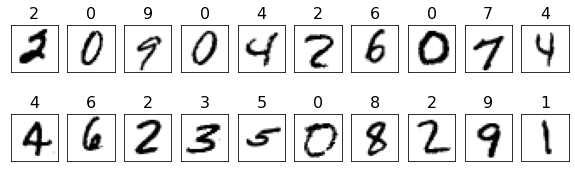

In [8]:
N=20
np.random.seed(123)
indexes=np.random.choice(y_test.shape[0],N,replace=False)
x_selected=x_test[indexes,1:]
y_selected=y_test[indexes]
plt.figure(figsize=(10,3))
for i in range(N):
    ax=plt.subplot(2,N/2,i+1)
    plt.imshow(x_selected[i].reshape(28,28),cmap='gray_r')
    ax.set_title('%d' %y_selected[i],fontsize=16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [10]:
def softmax(x):
    x=x.T
    x_max=x.max(axis=0)
    x=x-x_max
    w=np.exp(x)
    return (w/w.sum(axis=0)).T

In [11]:
def cross_entropy(yt,yp):
    return -np.mean(np.sum(yt*np.log(yp),axis=1))

In [12]:
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one,V,W):
    b1_test=np.insert(sigmoid(x_test@V),0,1,axis=1)
    yp_test_one=softmax(b1_test@W)
    yp_test=np.argmax(yp_test_one,axis=1)
    loss=cross_entropy(y_test_one,yp_test_one)
    score=accuracy_score(y_test,yp_test)
    return score,loss

In [13]:
import numpy as np

class Indexes():
    def __init__(self,total,size):
        self.total=total
        self.size=size
        self.indexes=np.zeros(0)
        
    def next_index(self):
        next_flag=False
        
        if len(self.indexes)<self.size:
            self.indexes=np.random.choice(self.total,
                self.total,replace=False)
            next_flag=True
            
        index=self.indexes[:self.size]
        self.indexes=self.indexes[self.size:]
        return index,next_flag

In [14]:
indexes=Indexes(20,5)

for i in range(6):
    arr,flag=indexes.next_index()
    print(arr,flag)

[10  7  9  1 17] True
[ 6 16  2 19 14] False
[ 3  5  0  4 12] False
[11 15 13 18  8] False
[11 16  4  3 10] True
[14  2 15 12  8] False


In [15]:
H=128
H1=H+1
M=x_train.shape[0]
D=x_train.shape[1]
N=y_train_one.shape[1]

nb_epoch=100
batch_size=512
B=batch_size
alpha=0.01

V=np.ones((D,H))
W=np.ones((H1,N))

history1=np.zeros((0,3))

indexes=Indexes(M,batch_size)
epoch=0

In [16]:
while epoch<nb_epoch:
    index,next_flag=indexes.next_index()
    x,yt=x_train[index],y_train_one[index]
    a=x@V
    b=sigmoid(a)
    b1=np.insert(b,0,1,axis=1)
    u=b1@W
    yp=softmax(u)
    
    yd=yp-yt
    bd=b*(1-b)*(yd@W[1:].T)
    
    W=W-alpha*(b1.T@yd) / B
    V=V-alpha*(x.T@bd) / B
    
    if next_flag:
        score,loss=evaluate(
            x_test,y_test,y_test_one,V,W)
        history1=np.vstack((history1,
            np.array([epoch,loss,score])))
        print("epoch=%d loss=%f score=%f"
             %(epoch,loss,score))
        epoch=epoch+1

epoch=0 loss=2.302439 score=0.113500
epoch=1 loss=2.301307 score=0.113500
epoch=2 loss=2.301645 score=0.113500
epoch=3 loss=2.301732 score=0.113500
epoch=4 loss=2.301102 score=0.113500
epoch=5 loss=2.301635 score=0.113500
epoch=6 loss=2.301448 score=0.113500
epoch=7 loss=2.302055 score=0.102800
epoch=8 loss=2.301286 score=0.113500
epoch=9 loss=2.301540 score=0.113500
epoch=10 loss=2.301582 score=0.113500
epoch=11 loss=2.301361 score=0.113500
epoch=12 loss=2.301060 score=0.113500
epoch=13 loss=2.301384 score=0.113500
epoch=14 loss=2.301371 score=0.113500
epoch=15 loss=2.301754 score=0.113500
epoch=16 loss=2.301033 score=0.113500
epoch=17 loss=2.301392 score=0.113500
epoch=18 loss=2.301134 score=0.113500
epoch=19 loss=2.301339 score=0.103200
epoch=20 loss=2.301380 score=0.113500
epoch=21 loss=2.301437 score=0.113500
epoch=22 loss=2.301182 score=0.113500
epoch=23 loss=2.301375 score=0.113500
epoch=24 loss=2.301780 score=0.102800
epoch=25 loss=2.301543 score=0.113500
epoch=26 loss=2.301869

In [17]:
print('[초기 상태] 손실함수: %f, 정확도: %f'
     %(history1[0,1],history1[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
     %(history1[-1,1],history1[-1,2]))

[초기 상태] 손실함수: 2.302439, 정확도: 0.113500
[최종 상태] 손실함수: 2.301456, 정확도: 0.113500


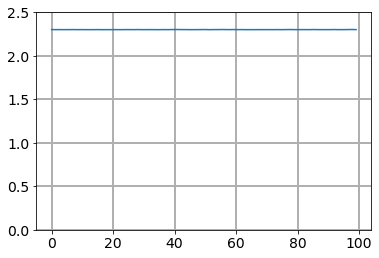

In [18]:
plt.plot(history1[:,0], history1[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

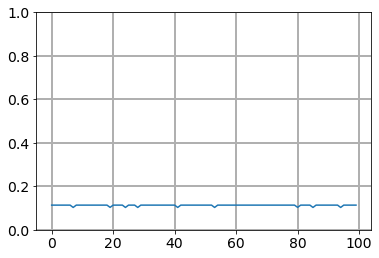

In [19]:
plt.plot(history1[:,0], history1[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

In [20]:
H=128
H1=H+1
M=x_train.shape[0]
D=x_train.shape[1]
N=y_train_one.shape[1]

alpha=0.01
nb_epoch=100
batch_size=512
B=batch_size

V=np.ones((D,H))
W=np.ones((H1,N))

history2=np.zeros((0,3))

indexes=Indexes(M,batch_size)
epoch=0

In [23]:
V=np.random.randn(D,H)/np.sqrt(D/2)
W=np.random.randn(H1,N)/np.sqrt(H1/2)
print(V[:2,:5])
print(W[:2,:5])

[[-0.05527311 -0.0372313  -0.02376794  0.05060651 -0.03286844]
 [ 0.03835526  0.05362109 -0.00095017  0.00546584  0.03471103]]
[[-0.07014677  0.06617931  0.08930029  0.05519621 -0.14201817]
 [-0.07945355 -0.04365724 -0.17398602 -0.03769788 -0.01366633]]


In [24]:
while epoch<nb_epoch:
    index,next_flag=indexes.next_index()
    x,yt=x_train[index],y_train_one[index]
    a=x@V
    b=sigmoid(a)
    b1=np.insert(b,0,1,axis=1)
    u=b1@W
    yp=softmax(u)
    
    yd=yp-yt
    bd=b*(1-b)*(yd@W[1:].T)
    
    W=W-alpha*(b1.T@yd) / B
    V=V-alpha*(x.T@bd) / B
    
    if next_flag:
        score,loss=evaluate(
            x_test,y_test,y_test_one,V,W)
        history2=np.vstack((history2,
            np.array([epoch,loss,score])))
        print("epoch=%d loss=%f score=%f"
             %(epoch,loss,score))
        epoch=epoch+1

epoch=0 loss=2.132527 score=0.439100
epoch=1 loss=1.976458 score=0.624500
epoch=2 loss=1.832359 score=0.685500
epoch=3 loss=1.698419 score=0.720900
epoch=4 loss=1.575098 score=0.747100
epoch=5 loss=1.462761 score=0.759900
epoch=6 loss=1.361271 score=0.774200
epoch=7 loss=1.270233 score=0.783000
epoch=8 loss=1.189433 score=0.794700
epoch=9 loss=1.117936 score=0.798300
epoch=10 loss=1.054308 score=0.807800
epoch=11 loss=0.998258 score=0.815500
epoch=12 loss=0.948299 score=0.820100
epoch=13 loss=0.904000 score=0.825200
epoch=14 loss=0.864538 score=0.831400
epoch=15 loss=0.829176 score=0.836700
epoch=16 loss=0.797438 score=0.841400
epoch=17 loss=0.768664 score=0.844300
epoch=18 loss=0.742741 score=0.847300
epoch=19 loss=0.719082 score=0.852100
epoch=20 loss=0.697836 score=0.854800
epoch=21 loss=0.678124 score=0.857100
epoch=22 loss=0.660056 score=0.859800
epoch=23 loss=0.643564 score=0.862000
epoch=24 loss=0.628205 score=0.864100
epoch=25 loss=0.613884 score=0.865900
epoch=26 loss=0.600794

In [25]:
print('[초기 상태] 손실함수: %f, 정확도: %f'
     %(history2[0,1],history2[0,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
     %(history2[-1,1],history2[-1,2]))

[초기 상태] 손실함수: 2.132527, 정확도: 0.439100
[최종 상태] 손실함수: 0.344773, 정확도: 0.905100


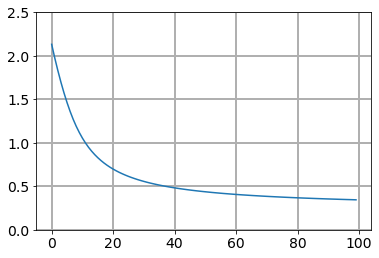

In [26]:
plt.plot(history2[:,0], history2[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

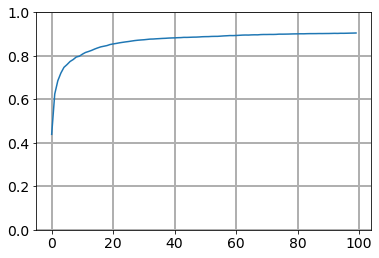

In [27]:
plt.plot(history2[:,0], history2[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

In [28]:
def ReLU(x):
    return np.maximum(0,x)

In [29]:
def step(x):
    return 1.0*(x>0)

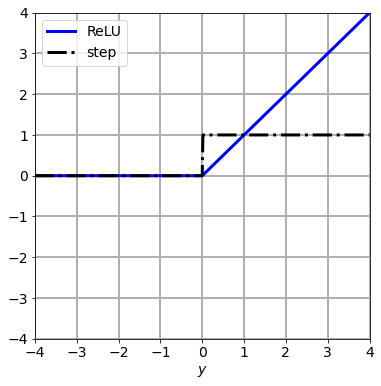

In [30]:
xx=np.linspace(-4,4,501)
yy=ReLU(xx)
plt.figure(figsize=(6,6))
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel(r'$x$',fontsize=14)
plt.xlabel(r'$y$',fontsize=14)
plt.grid(lw=2)
plt.plot(xx,ReLU(xx),c='b',label='ReLU',linestyle='-',lw=3)
plt.plot(xx,step(xx),c='k',label='step',linestyle='-.',lw=3)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

In [36]:
from sklearn.metrics import accuracy_score

def evaluate2(x_test,y_test,y_test_one,V,W):
    b1_test=np.insert(ReLU(x_test @ V),0,1,axis=1)
    yp_test_one=softmax(b1_test@W)
    yp_test=np.argmax(yp_test_one,axis=1)
    loss=cross_entropy(y_test_one,yp_test_one)
    score=accuracy_score(y_test,yp_test)
    return score, loss

In [37]:
H=128
H1=H+1
M=x_train.shape[0]
D=x_train.shape[1]
N=y_train_one.shape[1]

alpha=0.01
nb_epoch=100
batch_size=512
B=batch_size

V=np.random.randn(D,H)/np.sqrt(D/2)
W=np.random.randn(H1,N)/np.sqrt(H1/2)

history3=np.zeros((0,3))

indexes=Indexes(M,batch_size)
epoch=0

In [38]:
while epoch < nb_epoch:
    index,next_flag=indexes.next_index()
    x,yt=x_train[index],y_train_one[index]
    
    a=x@V
    b=ReLU(a)
    b1=np.insert(b,0,1,axis=1)
    u=b1@W
    yp=softmax(u)
    
    yd=yp-yt
    bd=step(a)*(yd@W[1:].T)
    
    W=W-alpha*(b1.T@yd) / B
    V=V-alpha*(x.T@bd) / B
    
    if next_flag:
        score,loss=evaluate2(
            x_test,y_test,y_test_one,V,W)
        history3=np.vstack((history3,
            np.array([epoch,loss,score])))
        print("epoch=%d loss=%f score=%f"
             %(epoch,loss,score))
        epoch=epoch+1

epoch=0 loss=2.383731 score=0.052000
epoch=1 loss=1.476055 score=0.691300
epoch=2 loss=0.994538 score=0.797700
epoch=3 loss=0.769368 score=0.834000
epoch=4 loss=0.648021 score=0.851700
epoch=5 loss=0.572879 score=0.865300
epoch=6 loss=0.521684 score=0.873000
epoch=7 loss=0.485155 score=0.879500
epoch=8 loss=0.456676 score=0.884000
epoch=9 loss=0.434504 score=0.888100
epoch=10 loss=0.416722 score=0.891400
epoch=11 loss=0.402239 score=0.893200
epoch=12 loss=0.389575 score=0.896200
epoch=13 loss=0.378929 score=0.897900
epoch=14 loss=0.369559 score=0.900700
epoch=15 loss=0.361064 score=0.902000
epoch=16 loss=0.353634 score=0.903600
epoch=17 loss=0.346909 score=0.904700
epoch=18 loss=0.340740 score=0.906100
epoch=19 loss=0.335026 score=0.908400
epoch=20 loss=0.330115 score=0.909100
epoch=21 loss=0.325298 score=0.910700
epoch=22 loss=0.320832 score=0.911400
epoch=23 loss=0.316926 score=0.912300
epoch=24 loss=0.312898 score=0.913500
epoch=25 loss=0.309495 score=0.914800
epoch=26 loss=0.305793

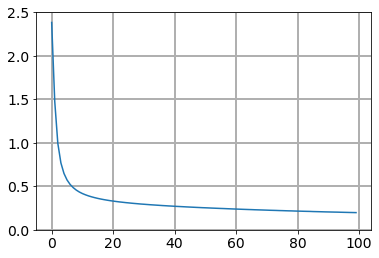

In [39]:
plt.plot(history3[:,0], history3[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

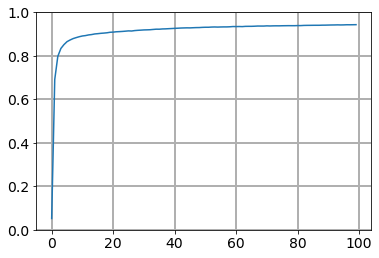

In [40]:
plt.plot(history3[:,0], history3[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

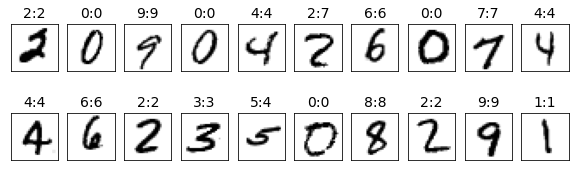

In [43]:
import matplotlib.pyplot as plt
N=20
np.random.seed(123)
indexes=np.random.choice(y_test.shape[0],N,replace=False)

x_selected=x_test[indexes]
y_selected=y_test[indexes]

b1_test=np.insert(ReLU(x_selected@V),0,1,axis=1)
yp_test_one=softmax(b1_test@W)
yp_test=np.argmax(yp_test_one,axis=1)

plt.figure(figsize=(10,3))
for i in range(N):
    ax=plt.subplot(2,N/2,i+1)
    plt.imshow(x_selected[i,1:].reshape(28,28),cmap='gray_r')
    ax.set_title('%d:%d'%(y_selected[i],yp_test[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [49]:
from sklearn.metrics import accuracy_score

def evaluate3(x_test, y_test, y_test_one,U,V,W):
    b1_test=np.insert(ReLU(x_test@U),0,1,axis=1)
    d1_test=np.insert(ReLU(b1_test@V),0,1,axis=1)
    yp_test_one=softmax(d1_test@W)
    yp_test=np.argmax(yp_test_one,axis=1)
    loss=cross_entropy(y_test_one,yp_test_one)
    score=accuracy_score(y_test,yp_test)
    return score,loss

In [52]:
H=128
H1=H+1
M=x_train.shape[0]
D=x_train.shape[1]
N=y_train_one.shape[1]

alpha=0.01
nb_epoch=100
batch_size=512
B=batch_size

U=np.random.randn(D,H)/np.sqrt(D/2)
V=np.random.randn(H1,H)/np.sqrt(H1/2)
W=np.random.randn(H1,N)/np.sqrt(H1/2)

history4=np.zeros((0,3))

indexes=Indexes(M,batch_size)
epoch=0

In [53]:
while epoch < nb_epoch:
    index,next_flag=indexes.next_index()
    x,yt=x_train[index],y_train_one[index]
    
    a=x@U
    b=ReLU(a)
    b1=np.insert(b,0,1,axis=1)
    c=b1@V
    d=ReLU(c)
    d1=np.insert(d,0,1,axis=1)
    u=d1@W
    yp=softmax(u)
    
    yd=yp-yt
    dd=step(c)*(yd@W[1:].T)
    bd=step(a)*(dd@V[1:].T)
    
    W=W-alpha*(d1.T@yd) / B
    V=V-alpha*(b1.T@dd) / B
    U=U-alpha*(x.T@bd) / B
    
    if next_flag:
        score,loss=evaluate3(
            x_test,y_test,y_test_one,U,V,W)
        history4=np.vstack((history4,
            np.array([epoch,loss,score])))
        print("epoch=%d loss=%f score=%f"
             %(epoch,loss,score))
        epoch=epoch+1

epoch=0 loss=2.565896 score=0.066100
epoch=1 loss=1.419696 score=0.713100
epoch=2 loss=0.827713 score=0.824000
epoch=3 loss=0.602315 score=0.857800
epoch=4 loss=0.498875 score=0.878100
epoch=5 loss=0.440854 score=0.888000
epoch=6 loss=0.403185 score=0.894800
epoch=7 loss=0.377940 score=0.900700
epoch=8 loss=0.357433 score=0.904900
epoch=9 loss=0.342377 score=0.907600
epoch=10 loss=0.329798 score=0.911400
epoch=11 loss=0.319769 score=0.913500
epoch=12 loss=0.310628 score=0.914400
epoch=13 loss=0.302661 score=0.916200
epoch=14 loss=0.295328 score=0.919200
epoch=15 loss=0.288610 score=0.920200
epoch=16 loss=0.282651 score=0.921200
epoch=17 loss=0.277663 score=0.922900
epoch=18 loss=0.273563 score=0.923600
epoch=19 loss=0.268110 score=0.925300
epoch=20 loss=0.263236 score=0.926800
epoch=21 loss=0.258994 score=0.928400
epoch=22 loss=0.256062 score=0.928500
epoch=23 loss=0.252367 score=0.928900
epoch=24 loss=0.248218 score=0.929700
epoch=25 loss=0.245043 score=0.930700
epoch=26 loss=0.241818

In [54]:
 print('[초기 상태] 손실함수: %f, 정확도: %f'
     %(history2[1,1],history2[1,2]))
print('[최종 상태] 손실함수: %f, 정확도: %f'
     %(history2[-1,1],history2[-1,2]))

[초기 상태] 손실함수: 1.976458, 정확도: 0.624500
[최종 상태] 손실함수: 0.344773, 정확도: 0.905100


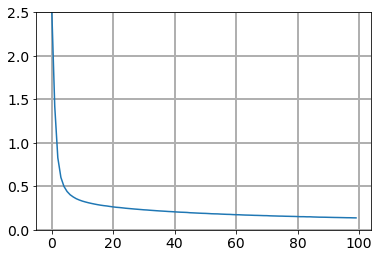

In [55]:
plt.plot(history4[:,0], history4[:,1])
plt.ylim(0,2.5)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

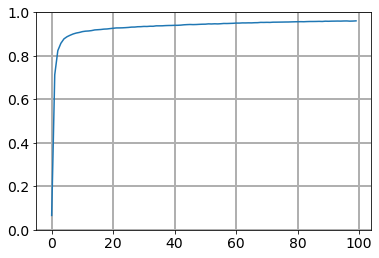

In [56]:
plt.plot(history4[:,0], history4[:,2])
plt.ylim(0,1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.show()

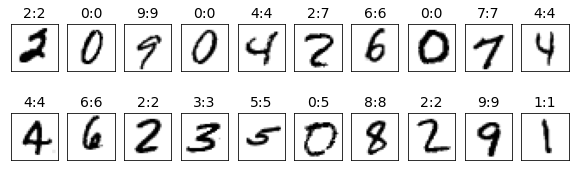

In [58]:
import matplotlib.pyplot as plt

N=20
np.random.seed(123)
indexes=np.random.choice(y_test.shape[0],N,replace=False)

x_selected=x_test[indexes]
y_selected=y_test[indexes]

b1_test=np.insert(ReLU(x_selected@U),0,1,axis=1)
d1_test=np.insert(ReLU(b1_test@V),0,1,axis=1)
yp_test_one=softmax(d1_test@W)
yp_test=np.argmax(yp_test_one,axis=1)

plt.figure(figsize=(10,3))
for i in range(N):
    ax=plt.subplot(2,N/2,i+1)
    plt.imshow(x_selected[i,1:].reshape(28,28),cmap='gray_r')
    ax.set_title('%d:%d'%(y_selected[i],yp_test[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()